In [1]:
from utils.model import light
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn

# 检查设备信息
light.DeviceUtils.print_device_info()

🔍 设备检测结果:
   PyTorch版本: 2.7.1+cu128
   CUDA: ❌
   MPS (Apple Silicon): ❌
   推荐设备: cpu


In [2]:
class SoftMaxRegression(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True  # 标记为分类任务
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10),  # 假设有10个类别
        )

    def compute_loss(self, y_hat, y):
        # 使用交叉熵损失
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, X):
        # 返回预测的类别
        return self.net(X).argmax(dim=1)

    def predict_class(self, X):
        # 返回预测的类别
        return self.predict(X).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


datapath = "../../data/"


In [3]:
class MLPSoftMax(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True  # 标记为分类任务
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(config.num_hiddens),
            nn.ReLU(),
            nn.LazyLinear(config.output_size), 
        )

    def compute_loss(self, y_hat, y):
        # 使用交叉熵损失
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, X):
        # 返回预测的类别
        return self.net(X).argmax(dim=1)

    def predict_class(self, X):
        # 返回预测的类别
        return self.predict(X).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }



In [ ]:
# 数据准备
datapath = "../../data/"

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# 加载数据集
fashion_mnist_train = datasets.FashionMNIST(
    root=datapath, train=True, download=True, transform=transformer
)
fashion_mnist_test = datasets.FashionMNIST(
    root=datapath, train=False, download=True, transform=transformer
)

# 创建标准数据加载器 - 无需GPU包装器！
train_loader = DataLoader(
    fashion_mnist_train, 
    batch_size=64, 
    shuffle=True, 
)
val_loader = DataLoader(
    fashion_mnist_test, 
    batch_size=64, 
    shuffle=False, 
)

num_classes = len(fashion_mnist_train.classes)
print(f"数据集类别数: {num_classes}")

数据集类别数: 10


In [5]:
# 创建配置 - 无需指定设备！
config = light.ModelConfig(
    lr=0.03,
    num_hiddens=256,
    output_size=num_classes,
    optimizer="sgd",  # 更好的优化器
    # weight_decay=1e-4,  # 正则化
)
model_linear = SoftMaxRegression(config)
model_mlp = MLPSoftMax(config)


print("模型创建完成！Lightning将自动处理设备管理。")

模型创建完成！Lightning将自动处理设备管理。


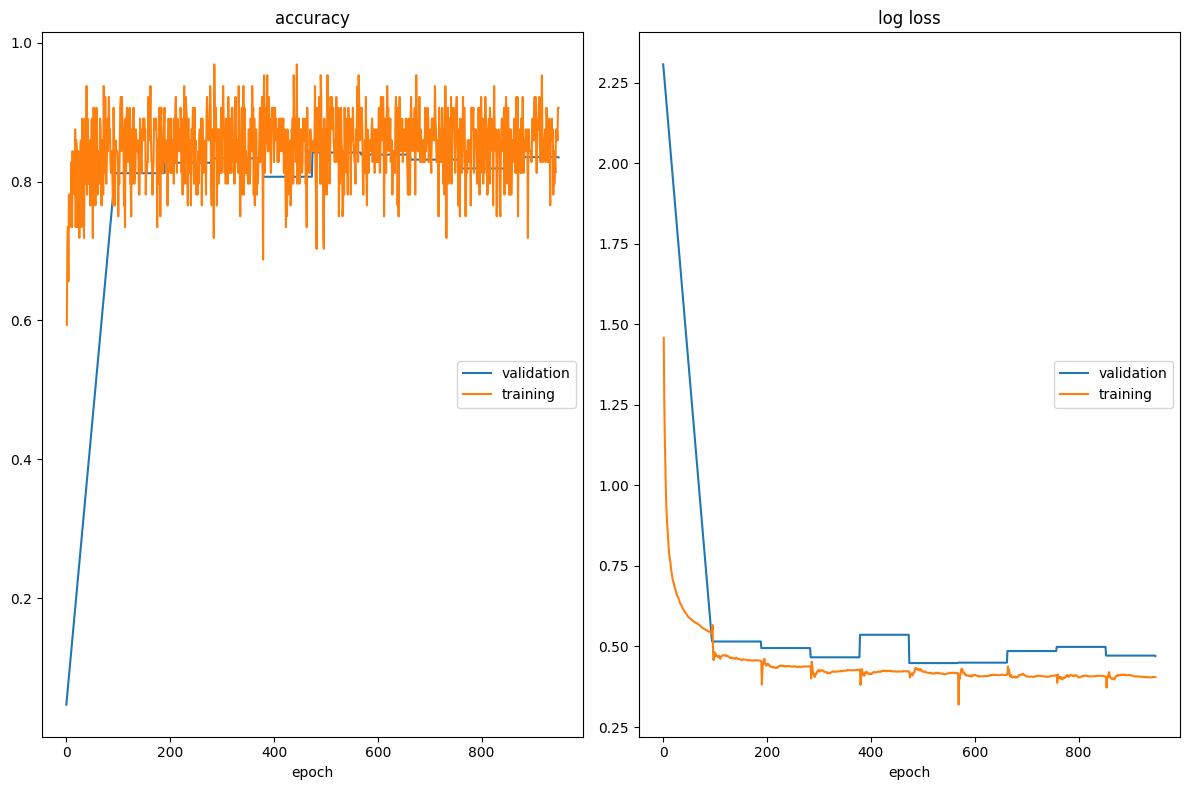

accuracy
	validation       	 (min:    0.047, max:    0.842, cur:    0.835)
	training         	 (min:    0.594, max:    0.969, cur:    0.906)
log loss
	validation       	 (min:    0.449, max:    2.307, cur:    0.470)
	training         	 (min:    0.319, max:    1.458, cur:    0.405)
Epoch 9: 100%|██████████| 938/938 [00:46<00:00, 20.25it/s, v_num=6, train_loss=0.241, train_acc=0.906, val_loss=0.470, val_acc=0.835]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:46<00:00, 20.24it/s, v_num=6, train_loss=0.241, train_acc=0.906, val_loss=0.470, val_acc=0.835]


In [6]:
# 训练线性模型
trainer_linear = light.TrainerFactory.basic(max_epochs=10)
trainer_linear.add_callback(light.HighFrequencyLiveLossPlotCallback())

print("🚀 开始训练线性模型...")
trainer_linear.fit(model_linear, train_loader, val_loader)

In [7]:
import pprint


res = model_linear.evaluate(
    torch.stack([x[0] for x in val_loader.dataset]),
    torch.tensor([x[1] for x in val_loader.dataset])
)
pprint.pprint(res)


{'accuracy': 0.8349000215530396,
 'loss': 0.47046327590942383,
 'predicted_class': tensor([9, 2, 1,  ..., 8, 1, 5])}


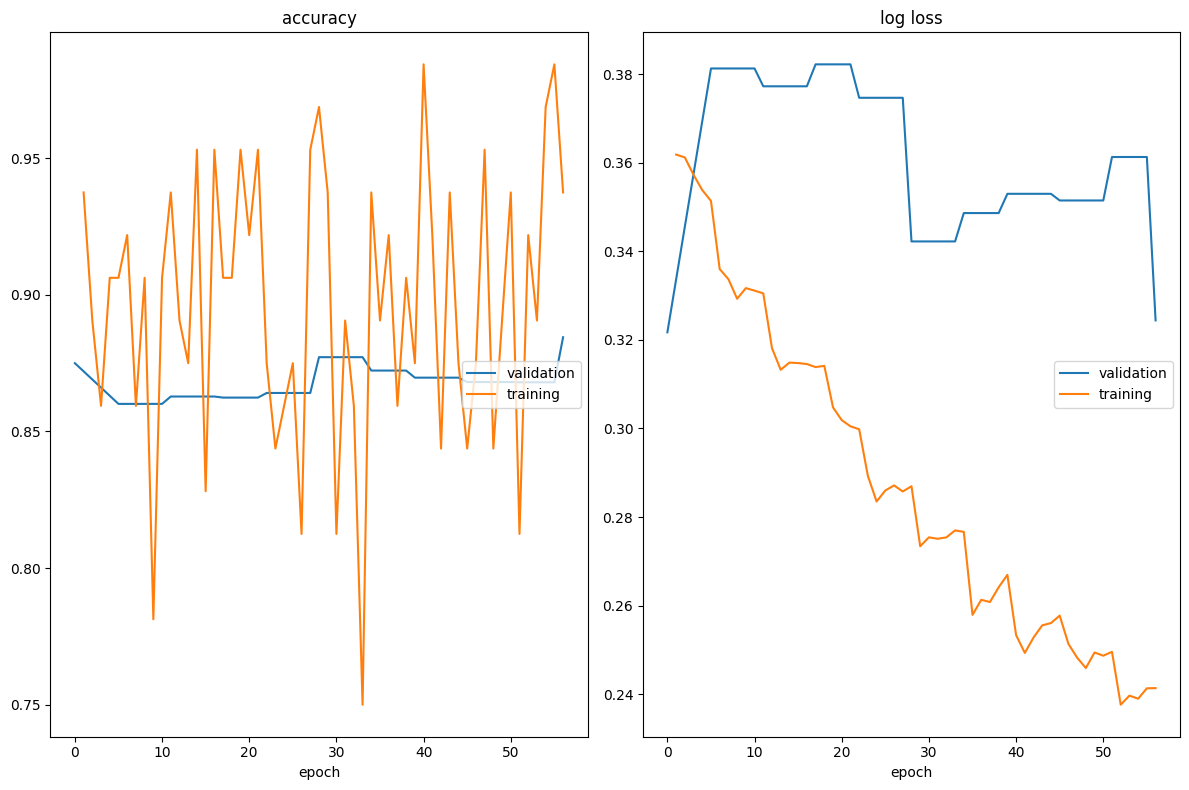

accuracy
	validation       	 (min:    0.860, max:    0.885, cur:    0.885)
	training         	 (min:    0.750, max:    0.984, cur:    0.938)
log loss
	validation       	 (min:    0.322, max:    0.382, cur:    0.324)
	training         	 (min:    0.238, max:    0.362, cur:    0.241)
Epoch 9: 100%|██████████| 938/938 [00:28<00:00, 33.01it/s, v_num=9, train_loss=0.247, train_acc=0.938, val_loss=0.324, val_acc=0.885]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:28<00:00, 32.99it/s, v_num=9, train_loss=0.247, train_acc=0.938, val_loss=0.324, val_acc=0.885]


In [10]:
trainer_mlp = light.TrainerFactory.basic(max_epochs=10)
trainer_mlp.add_callback(
    light.HighFrequencyLiveLossPlotCallback(update_every_n_batches=200)
)
print("🚀 开始训练MLP模型..."
      )
trainer_mlp.fit(model_mlp, train_loader, val_loader)

In [11]:
res = model_mlp.evaluate(
    torch.stack([x[0] for x in val_loader.dataset]),
    torch.tensor([x[1] for x in val_loader.dataset])
)
pprint.pprint(res)

{'accuracy': 0.8845000267028809,
 'loss': 0.32439425587654114,
 'predicted_class': tensor([9, 2, 1,  ..., 8, 1, 5])}
